## HW3 - Formulating IPs and Branch and Bound 

In this second homework assignment you will be asked to complete four different IP formulations in Gurobi. While we only ask you for some problems to write out the formulation before you implement it, we really recommend you do that work for every one of them -- it will make things much easier! 

Also, you will need to have numpy installed for this assignment. matplotlib is not strictly required, so if you dont have it installed, and don't want to, feel free to comment this out (and ignore the cells that contain "plt" below).

In [1]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt

#### Problem 1: Capital investment

A project manager in a company is considering a portfolio of 10 large project investments. These investments differ in the estimated long-run profit (net present value) they will generate as well as in the amount of capital required.

The lists P and C contain the estimated profit and capital required (both given in units of millions of USD) for investment opportunity j (j=1,...,10) in the jth index. The total amount of capital available for these investments is Q (in units of millions of USD)

Investment opportunities 3 and 4 are mutually exclusive and so are 5 and 6. Furthermore, neither 5 nor 6 can be undertaken unless either 3 or 4 is undertaken. At least two and at most four investment opportunities have to be undertaken from the set {1,2,7,8,9,10}.

The project manager wishes to select the combination of capital investments that will maximise the total estimated long-run profit subject to the restrictions described above.

Formulate and solve this problem using an integer programming model (optimal solution should come out as 215).

In [2]:
#estimated Profit
P = [15, 20, 25, 40, 30, 35, 50, 60, 30, 20]
#estimated Capital
C = [5, 10, 15, 20, 15, 20, 10, 40, 45, 30]
#total Captial available
Q = 100

In [3]:
m = gp.Model("investment portfolio")

investment = []
for n in range(10):
    investment.append(m.addVar(lb = 0, vtype=gp.GRB.BINARY))
    
#creating objective
m.setObjective(sum(P[n]*investment[n] for n in range(10)), gp.GRB.MAXIMIZE)

#setting constraints
m.addConstr(sum(C[n]*investment[n] for n in range(10)) <= Q)  #Capital Available
m.addConstr(investment[2] + investment[3] <= 1)   #Investment 3 and 4 are mutually exclusive
m.addConstr(investment[4] + investment[5] <= 1)   #Investment 5 and 6 are mutually exclusive
m.addConstr(investment[4] <= investment[2] + investment[3])   #Cannot invest in 5 unless invest in 3 or 4
m.addConstr(investment[5] <= investment[2] + investment[3])   #Cannot invest in 6 unless invest in 3 or 4
m.addConstr(investment[0] + investment[1] + investment[6] + investment[7] + investment[8] + investment[9] <= 4) #No more than 4 investments within 1/2/7/8/9/10
m.addConstr(investment[0] + investment[1] + investment[6] + investment[7] + investment[8] + investment[9] >= 2) #At least more than 2 investments within 1/2/7/8/9/10



m.optimize()

for n in range(10):
    print(investment[n])

Using license file C:\Users\lukec\gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 7 rows, 10 columns and 32 nonzeros
Model fingerprint: 0xf3a3bac5
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 200.0000000
Presolve time: 0.02s
Presolved: 7 rows, 10 columns, 32 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: objective 2.150000e+02, 3 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     215.0000000  215.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available 

What are the advantages and disadvantages of using this model for portfolio selection?

- The advantages of using a binary LP vs. intergerl LP to model the portfolio selection is that the constraints can easily be coded.
- The disadbantage of using a binary LP is we are restricting ourselves to only buying a maximum of 1 stock per investment option. This restricts the options and lowers the objective.

#### Problem 2: Facility location

In class we saw the problem of the garbage deposit stations in Amsterdam. Here, we want to solve a related problem, called ``facility location with service installation costs``. We are given, in the problem, the following:

- a set of customers that each have a service requirement
- a set of facilities that each have an opening cost (cost depends on facility) 
- a service installation cost that enables a facility to provide a particular service (depends on the facility and the service)
- an assignment cost of serving a customer through a facility (cost depends on facility and customer, but not on service)

The goal is to find (i) the set of facilities to open, (ii) what services to install in each facility, and (iii) what customers to assign to what facility so as to minimize the total costs (incl. opening, installation, and assignment).

Before you implement this in gurobi (with specific data), write down the decision variables and constraints we need to implement this optimization problem.

.

Now you should be ready to write the problem in gurobi. As usual, we first load all the data.

In [4]:
# These lists contain the facilities, the services, and the customers
facilities = ['f1', 'f2', 'f3']
services = ['s1', 's2', 's3', 's4']
customers = ['c1', 'c2', 'c3','c4','c5','c6', 'c7']

# the cost of opening any one facility are as follows
facility_opening_costs = {'f1': 13, 'f2': 15, 'f3': 12}

# Below are the costs of installing a service in an opened facility
# Notice that it's given in a so-called "nested dictionary"; the cost of installing service 
# s3 at facility f1 is service_installation_costs['f1']['s3'] which turns out 
# to be 1 (in this example)
service_installation_costs = {'f1': {'s1':2, 's2':4, 's3':1, 's4':2},
                              'f2': {'s1':1, 's2':1, 's3':1, 's4':0},
                              'f3': {'s1':2, 's2':4, 's3':1, 's4':2}}

# For each customer, the below dictionary captures what service they require
customer_service_needs = {'c1': 's1', 'c2': 's1', 'c3': 's2', 
                          'c4':'s2', 'c5':'s3', 'c6': 's3', 'c7':'s4'}

# For each pair of customer and facility, this nested dictionary captures 
# the cost of connecting facility f and customer c. so
# facility_customer_assignment_costs['f3']['c4'] would give the cost of
# connecting facility 3 and customer 4 (in this case: 6)
facility_customer_assignment_costs = {'f1': {'c1':4, 'c2':4, 'c3':3, 'c4':4, 'c5':5, 'c6':7, 'c7':8},
                                     'f2': {'c1':4, 'c2':4, 'c3':3, 'c4':4, 'c5':5, 'c6':7, 'c7':8},
                                     'f3': {'c1':5, 'c2':2, 'c3':1, 'c4':6, 'c5':15, 'c6':6, 'c7':7}
                                     }

With that data given and your IP formulation written out above, you should be able to formulate this in gurobi (optimal solution should come out as 53). If you think your formulation is correct, but you're getting stuck here, reach out to the teaching team!

In [10]:
m = gp.Model("Facility Location")

# DECISION VARIABLES
# Whether a location is open or not
facilities_open = {}
for facility in facilities:
    facilities_open[facility] = m.addVar(name = str(facility), vtype = gp.GRB.BINARY)

# Whether a facility has the respective service
facilities_service = {}
for facility in facilities:
    for service in services:
        facilities_service[(facility,service)] = m.addVar(name = str((facility,service)), vtype = gp.GRB.BINARY)

# Whether a facility has the respective customer
facilities_customer = {}
for facility in facilities:
    for customer in customers:
        facilities_customer[(facility,customer)] = m.addVar(name = str((facility,customer)), vtype = gp.GRB.BINARY)

# OBJECTIVE FUNCTION
m.setObjective(sum(facilities_open[facility]*facility_opening_costs[facility] for facility in facilities)
               + sum(service_installation_costs[facility][service]*facilities_service[(facility,service)] for facility in facilities for service in services)
               + sum(facility_customer_assignment_costs[facility][customer]*facilities_customer[(facility,customer)] for facility in facilities for customer in customers),
               gp.GRB.MINIMIZE)

# CONSTRAINTS
# Facilities can only have services if open
for facility in facilities:
    for service in services:
        m.addConstr(facilities_service[(facility,service)] <= facilities_open[facility])

# Customer can only be assigned to facility if open
for facility in facilities:
    for customer in customers:
        m.addConstr(facilities_customer[(facility,customer)] <= facilities_open[facility])
        
# Customer can only be assigned once
for customer in customers:
    m.addConstr(sum(facilities_customer[(facility,customer)] for facility in facilities) == 1)
    
# Customer must be assigned to appripriate service
for customer in customers:
    for facility in facilities:
        m.addConstr(facilities_customer[(facility,customer)] <= facilities_service[(facility, customer_service_needs[customer])])

m.optimize()

for facility in facilities:
    print(facilities_open[facility])

for facility in facilities:
    for service in services:
        print(facilities_service[(facility,service)])
        
for facility in facilities:
    for customer in customers:
        print(facilities_customer[(facility,customer)])


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 61 rows, 36 columns and 129 nonzeros
Model fingerprint: 0xa3c75f4b
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 89.0000000
Presolve removed 24 rows and 3 columns
Presolve time: 0.00s
Presolved: 37 rows, 33 columns, 81 nonzeros
Variable types: 0 continuous, 33 integer (33 binary)

Root relaxation: objective 5.300000e+01, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      53.0000000   53.00000  0.00%     -    0s

Explored 0 nodes (27 simplex iterations) in 0.10 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 53 89 

Optimal so

In class we also briefly spoke about capacities on facilities. Suppose we can only connect at most 4 customers to a facility. Take your previous optimization problem and solve it with such a constraint added for each facility (optimal solution should come out as 65).

In [9]:
m = gp.Model("Facility Location")

# DECISION VARIABLES
# Whether a location is open or not
facilities_open = {}
for facility in facilities:
    facilities_open[facility] = m.addVar(name = str(facility), vtype = gp.GRB.BINARY)

# Whether a facility has the respective service
facilities_service = {}
for facility in facilities:
    for service in services:
        facilities_service[(facility,service)] = m.addVar(name = str((facility,service)), vtype = gp.GRB.BINARY)

# Whether a facility has the respective customer
facilities_customer = {}
for facility in facilities:
    for customer in customers:
        facilities_customer[(facility,customer)] = m.addVar(name = str((facility,customer)), vtype = gp.GRB.BINARY)

# OBJECTIVE FUNCTION
m.setObjective(sum(facilities_open[facility]*facility_opening_costs[facility] for facility in facilities)
               + sum(service_installation_costs[facility][service]*facilities_service[(facility,service)] for facility in facilities for service in services)
               + sum(facility_customer_assignment_costs[facility][customer]*facilities_customer[(facility,customer)] for facility in facilities for customer in customers),
               gp.GRB.MINIMIZE)

# CONSTRAINTS
# Facilities can only have services if open
for facility in facilities:
    for service in services:
        m.addConstr(facilities_service[(facility,service)] <= facilities_open[facility])

# Customer can only be assigned to facility if open
for facility in facilities:
    for customer in customers:
        m.addConstr(facilities_customer[(facility,customer)] <= facilities_open[facility])
        
# Customer can only be assigned once
for customer in customers:
    m.addConstr(sum(facilities_customer[(facility,customer)] for facility in facilities) == 1)
    
# Customer must be assigned to appripriate service
for customer in customers:
    for facility in facilities:
        m.addConstr(facilities_customer[(facility,customer)] <= facilities_service[(facility, customer_service_needs[customer])])        

# Facility can only have 4 customers max
for facility in facilities:
    m.addConstr(sum(facilities_customer[(facility,customer)] for customer in customers) <= 4)

m.optimize()
    
for facility in facilities:
    print(facilities_open[facility])

for facility in facilities:
    for service in services:
        print(facilities_service[(facility,service)])
        
for facility in facilities:
    for customer in customers:
        print(facilities_customer[(facility,customer)])

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 64 rows, 36 columns and 150 nonzeros
Model fingerprint: 0xa2b10752
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 89.0000000
Presolve removed 24 rows and 3 columns
Presolve time: 0.00s
Presolved: 40 rows, 33 columns, 102 nonzeros
Variable types: 0 continuous, 33 integer (33 binary)

Root relaxation: objective 5.471429e+01, 35 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   54.71429    0   22   89.00000   54.71429  38.5%     -    0s
H    0     0                      82.0000000   54.71429  33.3%     -    0s
H    0     0                      75.0000000   54.71429  27.0%    

#### Problem 3: Market experiment design

Consider the following problem that might arise in an online transportation platform that services different regions.  Suppose the company wants to run an experiment in which some markets receive ``treatment`` whereas other markets are in a ``conrol`` group. Because some of the users of the platform (think drivers at Lyft/Uber, truckers at Convoy, etc) might be engaged in more than one market (e.g., drivers for Lyft may be driving in both NJ and NYC), the companies must be careful about effects that occur between the different markets (e.g., a driver being in a control market, but having driven in the market nearby and thus been exposed to the treaetment). Thus, they may want to have not just a treatment and a control group in their experiment, but also a group of markets that are not treated as either, because it may experience some of the treatment effects despite not being in the treatment group.

As we set up the problem, read the comments in the cells that describe what is going on.

PS: While irrelevant for this optimization, for this to make sense we need some rather strong assumptions about markets being "equivalent". To get around these, one can come up with specialized experimental designs that are way beyond the scope of this exercise.

[]

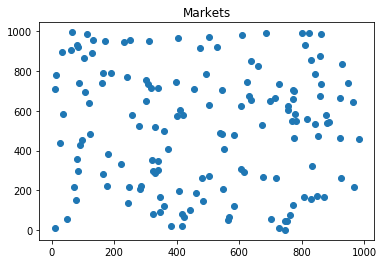

In [7]:
# We first create our data: we assume we have 200 markets and they are located uniformly at random within 
# a rectangle. Run this cell to see their locations visualized
num_markets = 150
markets = np.array([np.random.uniform(0,1000, num_markets), np.random.uniform(0,1000, num_markets)])
plt.scatter(markets[0],markets[1])
plt.title('Markets')
plt.plot()

We assume that two markets are too close for one to be in the control and the other in the treatment, if their l1-distance is at most 400. list_of_dependencies will have one element for every pair of markets that are too close for one to be in treatment and the other in control.

In [8]:
# list_of_dependencies is initializeed as empty; as we iterate over pairs of markets,
# we add a pair of points to the list if the points are too close to each other
list_of_dependenecies = []
market_indices = [m for m in range(num_markets)]
for m1 in market_indices:
    for m2  in market_indices:
        if abs(markets[0][m1]-markets[0][m2]) + abs(markets[1][m1]-markets[1][m2]) <=400:
            list_of_dependenecies.append((m1,m2))

0 2


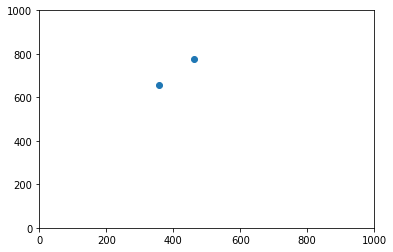

In [4]:
# For example if you run this cell, you find one pair that would be too close:
m1, m2 = list_of_dependenecies[1]
print(m1,m2)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.scatter([markets[0][m1],markets[0][m2]], [markets[1][m1],markets[1][m2]])

Now, you should optimize for the largest possible treatment and control groups, i.e., the optimization should give you the maximum number of markets to run the experiment in. Notice, that (i) we may not have control markets that are "near" a treatment market (based on list_of_dependencies), and (ii) we want the number of control and treatment markets to be the same.

Hint: if you use dictionaries called "markets_in_control" and "markets_in_treatment" that have a binary for each market, then the next cell below will visualize how you split up the markets

In [9]:
m = gp.Model("Market Experiment Design")


# DECISION VARIABLES
markets_in_control = {}
markets_in_treatment = {}

for market in market_indices:
    markets_in_control[market] = m.addVar(name = "market" + str(market), vtype = gp.GRB.BINARY)
    markets_in_treatment[market] = m.addVar(name = "market" + str(market), vtype = gp.GRB.BINARY)
    
# OBJECTIVE
m.setObjective(sum(markets_in_control[market] for market in market_indices) + 
               sum(markets_in_treatment[market] for market in market_indices), gp.GRB.MAXIMIZE)

# CONSTRAINTS
# Cannot be both control and treatment
for market in market_indices:
    m.addConstr(markets_in_control[market] + markets_in_treatment[market] <= 1)
    
# Same number of control and treatment
m.addConstr(sum(markets_in_control[market] for market in market_indices) == 
            sum(markets_in_treatment[market] for market in market_indices))

# Dependent markets cannot be control and treatment
for market_pair in list_of_dependenecies:
    m.addConstr( markets_in_control[market_pair[0]] + markets_in_treatment[market_pair[1]] <= 1)
    m.addConstr( markets_in_control[market_pair[1]] + markets_in_treatment[market_pair[0]] <= 1)

m.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 10935 rows, 300 columns and 22168 nonzeros
Model fingerprint: 0xe68eb9e3
Variable types: 0 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 5542 rows and 0 columns
Presolve time: 0.14s
Presolved: 5393 rows, 300 columns, 11084 nonzeros
Variable types: 0 continuous, 300 integer (300 binary)

Root relaxation: objective 1.500000e+02, 267 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  150.00000    0  300   -0.00000  150.00000      -     -    0s
H    0     0                      96.0000000  150.00000  56.3%     -    0s
H    0     0                     106.0000000  14

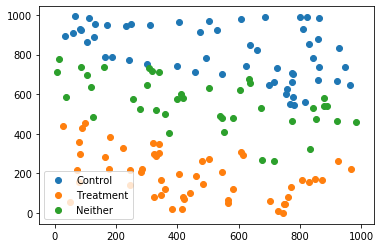

In [10]:
control, treatment = [], []
for market in market_indices: 
    if markets_in_control[market].x==1: control.append(market)
    if markets_in_treatment[market].x==1: treatment.append(market)
plt.scatter([markets[0][market] for market in control], [markets[1][market] for market in control],
           label = 'Control')
plt.scatter([markets[0][market] for market in treatment], [markets[1][market] for market in treatment]
           ,label='Treatment')
plt.scatter([markets[0][market] for market in market_indices if not (market in control or market in treatment)], 
            [markets[1][market] for market in market_indices if not (market in control or market in treatment)],
           label='Neither')
plt.plot()
plt.legend()

#### Problem 4: Optimal Shift Planning

In the planning of monthly production for the next months a company must, in each month, operate either a normal shift or an extended shift (if it produces at all - it can also "not produce"). We will aim to minimize the company's payroll costs while satisfying all production requirements. 

The payroll costs of a normal shift are (all costs are in USD) 100,000 per month, and in a month that is run as a normal shift up to 6,000 units can be produced. An extended shift month costs 180,000 and allows for production of up to 11,000 units per month. Production constraints are such that if the company produces anything at all in a particular month it must produce at least 2,000 units.

A month with no production happening costs 20,000. Note here that, for either type of shift, the cost incurred is fixed by a union guarantee agreement and so is independent of the amount produced.

However, the company also incurs an cost of 100,000 each time it changes from a normal shift or a no-production shift in one month to an extended shift in the next month. No extra cost is incurred in changing the production schedule between any other types of shifts (e.g., from normal month to no production incurs 0 cost, same for going from an extended shift in one month to a normal shift in the next). This extra cost is also not inccurred when remaining in extended shift for several consecutive months.

The cost of holding stock is $20 per unit per month and is based on the stock held at the end of each month, after demand for that month has been satisfied. The initial stock is 3,000 units. However, the amount in stock at the end of the last month should also be at least 2,000 units. In the most recent month (relevant for cost of switching to extended shift) the company operated in a normal shift. The demand for the company's product in each of the months is known to be as provided in the list "demand" below.

The company wants a production plan for the next months that avoids stockouts (i.e., meets all demand), and minimizes the combined costs that are described above. Formulate and solve this problem as an integer program (optimal solution should come out as 1.84M).

Hint: it may pay off to have up to 6 kinds of decision variables for each month: three binaries that signal the type of production (no production, normal, extended), one continuous variable for the production quantities, another continuous one for the leftover inventory at the end of a month (both of these may also be integer), and binary variables that signal whether extended production occurs in one month after normal/no production in the previous.

In [27]:
demand = [3000, 4000, 9000,0, 7000, 15000, 5000, 10000, 5000, 11000, 2000, 0]
num_months = len(demand)-1

normal_cost = 100000
normal_production = 6000
minimum_production = 2000

extended_cost = 180000
extended_production = 11000

no_production_cost = 20000

cost_of_changing_to_extended = 100000

holding_cost_per_unit = 20
initial_stock = 3000
end_inventory = 2000

m = gp.Model("Optimal Shift Planning")

# DECISION VARIABLES
no_production = {}
normal_shift = {}
extended_shift = {}
monthly_production = {}
monthly_inventory = {}
switch_to_extended = {}

for month in range(num_months):
    no_production[month] = m.addVar(name = "no_prod" + str(month), vtype = gp.GRB.BINARY)
    normal_shift[month] = m.addVar(name = "norm_shift" + str(month), vtype = gp.GRB.BINARY)
    extended_shift[month] = m.addVar(name = "ext_shift" + str(month), vtype = gp.GRB.BINARY)
    monthly_production[month] = m.addVar(name = "month_prod" + str(month), vtype = gp.GRB.INTEGER)
    monthly_inventory[month] = m.addVar(name = "month_inv" + str(month), vtype = gp.GRB.INTEGER)
    switch_to_extended[month] = m.addVar(name = "shift_to_ext" + str(month), vtype = gp.GRB.BINARY)
    

# OBJECTIVE
m.setObjective(sum(normal_shift[month]*normal_cost for month in range(num_months)) +
               sum(extended_shift[month]*extended_cost for month in range(num_months)) +
               sum(no_production[month]*no_production_cost for month in range(num_months)) +
               sum(monthly_inventory[month]*holding_cost_per_unit for month in range(num_months)) + 
               sum(switch_to_extended[month]*cost_of_changing_to_extended for month in range(num_months)),
               gp.GRB.MINIMIZE)

# CONSTRAINTS
# Factory must be in normal shift, extended shift or no production each month
for month in range(num_months):
    m.addConstr(normal_shift[month] + extended_shift[month] + no_production[month] == 1)
    
# Inventory must be greater than 2000 at the end of the last month
m.addConstr(monthly_inventory[num_months - 1] >= end_inventory)

# End inventory is equal to production minus demand
# Month 0
m.addConstr(initial_stock + monthly_production[0] - demand[0]  == monthly_inventory[0])

# Rest of Months
for month in range(1,num_months):
    m.addConstr(monthly_inventory[month-1] + monthly_production[month] - demand[month]  == monthly_inventory[month])
    
# Monthly production greater than 2000 units if factory is open
for month in range(num_months):
    m.addConstr(monthly_production[month] >= 2000*(normal_shift[month] + extended_shift[month]))
    
# Monthly production is 0 if closed
for month in range(num_months):
    m.addConstr(monthly_production[month] <= 99999*(1 - no_production[month]))
    
# Normal Shift can only produce 6000 units
for month in range(num_months):
    m.addConstr(monthly_production[month] <= 99999 - (99999-normal_production)*(normal_shift[month]))

# Extended Shift can only produce 11000 units
for month in range(num_months):
    m.addConstr(monthly_production[month] <= 99999 - (99999-extended_production)*(extended_shift[month]))

# Extended Shift must produce more than 6000 units
for month in range(num_months):
    m.addConstr(monthly_production[month] >= 6000*extended_shift[month])
    
# If switching from Normal Shift or No Production to Extended Shift, decision variable for Extended Shift will be 1
# Month 0
m.addConstr(extended_shift[0] <= switch_to_extended[0])

# Rest of months
for month in range(1,num_months):
    m.addConstr(no_production[month-1] + normal_shift[month-1] + extended_shift[month] - 1 <=
                switch_to_extended[month])
    
m.optimize()

for month in range(num_months):
    print(normal_shift[month].x, extended_shift[month].x, no_production[month].x, switch_to_extended[month].x)

for month in range(num_months):
    print(monthly_production[month].x, demand[month], monthly_inventory[month].x)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 89 rows, 66 columns and 229 nonzeros
Model fingerprint: 0x19e7f777
Variable types: 0 continuous, 66 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 3160000.0000
Presolve removed 20 rows and 8 columns
Presolve time: 0.00s
Presolved: 69 rows, 58 columns, 185 nonzeros
Variable types: 0 continuous, 58 integer (40 binary)

Root relaxation: objective 4.678005e+05, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 467800.453    0   16 3160000.00 467800.453  85.2%     -    0s
H    0     0                    1872480.0000 467800.453  75.0%     -    0s
H    0     0                    1860000.0000 467800.453  74.8%  